In [ ]:

# Step 1: Install required libraries
!pip install -q pandas numpy nltk scikit-learn matplotlib textblob transformers


In [ ]:
# Step 2: Imports
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

# NLTK resource downloads
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Step 3: Load dataset
df = pd.read_csv("flipkart_fashion.csv")  # Make sure this file is uploaded to Colab

# Step 4: Remove fake-looking entries
def is_faker_text(text):
    if pd.isna(text) or len(text.split()) < 6:
        return True
    buzzwords = ['project', 'political', 'charge', 'staff', 'discussion', 'interest', 'material']
    return sum(word in text.lower() for word in buzzwords) > 4

df = df[~df['FeedbackText'].apply(is_faker_text)].copy()
df.dropna(subset=['FeedbackText', 'FeedbackScore'], inplace=True)


In [ ]:
# Step 5: Sentiment label from FeedbackScore
def label_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['TrueSentiment'] = df['FeedbackScore'].apply(label_sentiment)

# Step 6: Clean text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['FeedbackText'].apply(preprocess)


In [ ]:
# Step 7: VADER sentiment analysis
sid = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER'] = df['clean_text'].apply(vader_sentiment)

# Step 8: TextBlob sentiment analysis
def textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['TextBlob'] = df['clean_text'].apply(textblob_sentiment)


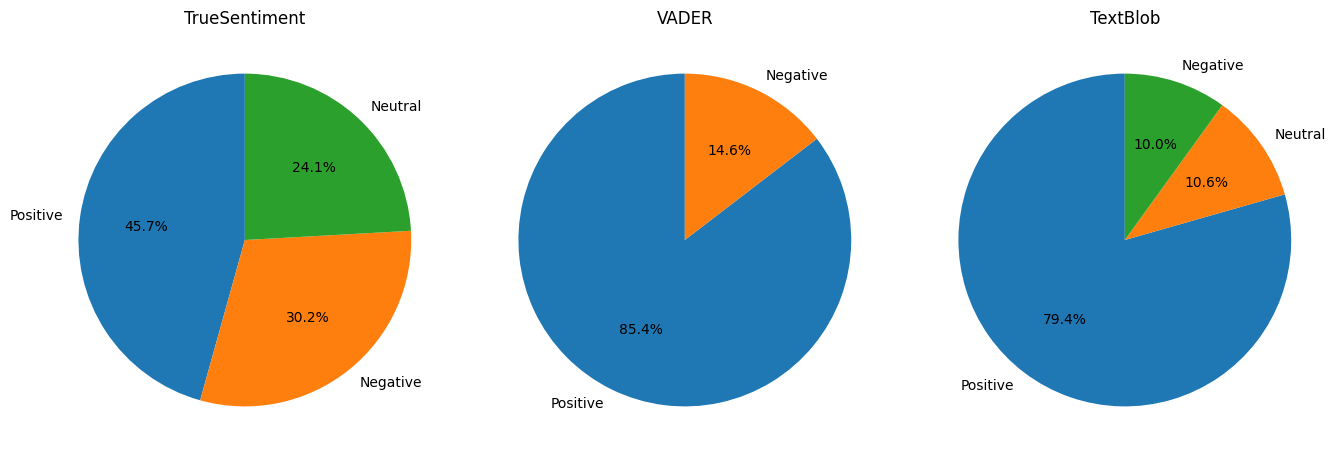

In [ ]:
# Step 10: Pie Chart of Sentiment by Methods
plt.figure(figsize=(18,10))

for idx, method in enumerate(['TrueSentiment', 'VADER', 'TextBlob']):
    plt.subplot(1, 4, idx+1)
    df[method].value_counts().plot.pie(autopct='%1.1f%%', title=method, startangle=90)
    plt.ylabel('')

plt.tight_layout()
plt.show()
